## Testing Cat Opmtisation algorithm on benchmark functions

In [4]:
#Some benchmarks functon
import cso
import math
import matplotlib.pyplot as plt
import numpy as np

def sphere(x):
    return sum([i**2 for i in x])

def rosenbrock(x):
    return sum([100*(x[i+1]-x[i]**2)**2 + (x[i]-1)**2 for i in range(len(x)-1)])

def rastrigin(x):
    return 10*len(x) + sum([i**2 - 10*math.cos(2*math.pi*i) for i in x])

def ackley(x):
    return -20*math.exp(-0.2*math.sqrt(sum([i**2 for i in x])/len(x))) - math.exp(sum([math.cos(2*math.pi*i) for i in x])/len(x)) + 20 + math.e

def griewank(x):
    return sum([i**2/4000 for i in x]) - math.prod([math.cos(i/math.sqrt(j+1)) for j, i in enumerate(x)]) + 1

def schwefel(x):
    return 418.9829*len(x) - sum([i*math.sin(math.sqrt(abs(i))) for i in x])

sphere : 1.8767609935787348e-10
rosenbrock : 0.017496794336003645
rastrigin : 4.2219356623925455
ackley : 1.6577555606815326
griewank : 5.903758793968903
schwefel : 755.4789311991309


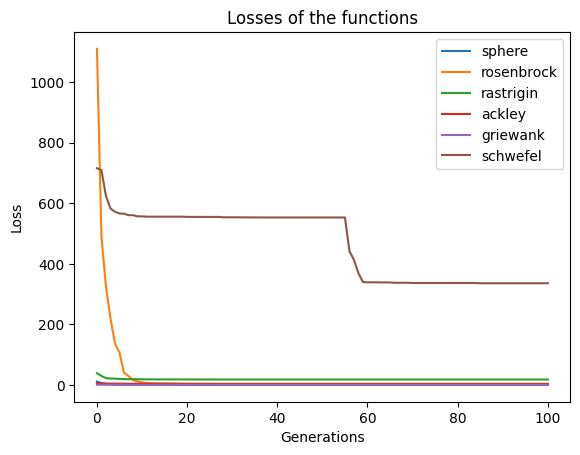

In [5]:
dim = 5
functions = [sphere, rosenbrock, rastrigin, ackley, griewank, schwefel]
optimals = [0, 0, 0, 0, 0, 420.9687]
min_values = [-5]*dim
max_values = [5]*dim

for f in functions:
    if f == schwefel:
        min_values = [-500]*dim
        max_values = [500]*dim
    losses,best_cat = cso.cat_swarm_optimization(size = 15, min_values = min_values, max_values = max_values, generations = 100, mixture_ratio = 0.2, seeking_range = 0.2, dim_change = 2, c1 = 0.5, target_function = f, verbose = False, start_init = None, target_value = None)
    #distance from optimal L2

    dist = np.linalg.norm(best_cat[:-1] - [optimals[functions.index(f)]]*dim)

    #plot the losses in one graph
    plt.plot(losses, label = f.__name__)
    plt.xlabel("Generations")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Losses of the functions")
    print(f.__name__, ":", dist)

plt.show()

## Applciation to NLP

In [6]:
import nltk
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer   # module for tokenizing tweets
from nltk.stem import PorterStemmer        # module for stemming
from nltk.corpus import stopwords        #Stopwords

import string,re,json,pickle
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


### Get tweeets

In [7]:
#Uncomment this line to download tweets for the first time
#nltk.download('twitter_samples')

#Get the pos/neg tweets as a list of strings
pos_tweets = twitter_samples.strings('positive_tweets.json')
neg_tweets = twitter_samples.strings('negative_tweets.json')

print("There are",len(pos_tweets),"postive tweets and",len(neg_tweets),"negative tweets")

There are 5000 postive tweets and 5000 negative tweets


#### Preprocess

In [8]:
#Get the english stopwords
stopwords_english = stopwords.words('english')

#Create tokenizer
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True)

#Create Stemmer 
stemmer = PorterStemmer() 

#Get stopwords and ponctuation
stopwords_english = stopwords.words('english') 
ponctuation = string.punctuation

def process_tweet(tweet):
    """
    input:
        tweet : string
        
    output:
        tweets_stem : List of token of the proceced tweet (ready to be vectorize)
    """
    #remove hyper links,RT,# and @ and numbers
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    tweet = re.sub(r'@[A-Za-z0-9]+', '', tweet)
    tweet = re.sub(r'[0-9]+', '', tweet)

    
    #Tokenize
    tweet = tokenizer.tokenize(tweet)
    
    #Remove stop words and punctuations
    tweet = [token for token in tweet if token not in stopwords_english and token not in ponctuation]
    
    #Stem
    tweet = [stemmer.stem(token) for token in tweet]

    return tweet

In [9]:
#shuffle the tweets
np.random.seed(42)
np.random.shuffle(pos_tweets)
np.random.shuffle(neg_tweets)

train_x = pos_tweets[:4000]+neg_tweets[:4000]
train_y = np.append(np.ones(4000),np.zeros(4000))

test_x = pos_tweets[4000:]+neg_tweets[4000:]
test_y = np.append(np.ones(1000),np.zeros(1000))

#Process the tweets
preprocessed_tweets_train = [process_tweet(tweet) for tweet in train_x]
preprocessed_tweets_test = [process_tweet(tweet) for tweet in test_x]

In [10]:
print("Before preprocessing ",train_x[0])
print("Exemple of a preprocessed tweet ",preprocessed_tweets_train[0])

Before preprocessing  @Sanza_T @LeratoTmohale Does the bag do the job Sanza?  :-)
Exemple of a preprocessed tweet  ['_t', 'bag', 'job', 'sanza', ':-)']


### TF_IDF

$$w_{x,y}=tf_{x,y}log(\frac{N}{df_x})$$
* $tf_{x,y}$ : Frequency of x in y
* $df_x$ : Number of documents containing x
* $N$ : Total number of docuements

In [11]:
#Get the vocabulary
vocab = set()
for tweet in preprocessed_tweets_train:
    for word in tweet:
        vocab.add(word)

for tweet in preprocessed_tweets_test:
    for word in tweet:
        vocab.add(word)

vocab = list(vocab)
vocab_size = len(vocab)

In [12]:
def tf_idf(preprocessed_tweets=preprocessed_tweets_train):
    N = len(preprocessed_tweets)

    #Create the frequency matrix of x in y
    tf_matrix = np.zeros((N,vocab_size))

    for i,tweet in enumerate(preprocessed_tweets):
        for j,word in enumerate(vocab):
            tf_matrix[i,j] = tweet.count(word)

    #create df x
    df = np.zeros(vocab_size)

    for i,word in enumerate(vocab):
        df[i] = sum([1 for tweet in preprocessed_tweets if word in tweet])

    df+=1e-9

    #Create idf
    #Create the idf matrix
    idf = np.log(N/df)

    #Create the tf-idf matrix
    tf_idf_matrix = tf_matrix*idf

    return tf_idf_matrix

In [13]:
tf_idf_matrix_train = tf_idf(preprocessed_tweets_train)
tf_idf_matrix_test = tf_idf(preprocessed_tweets=preprocessed_tweets_test)

In [14]:
print("Shape of the tf-idf matrix",tf_idf_matrix_train.shape)
print("Shape of the tf-idf matrix",tf_idf_matrix_test.shape)

Shape of the tf-idf matrix (8000, 10692)
Shape of the tf-idf matrix (2000, 10692)


### Visualise the data in a 2D reducted space

In [15]:
#data visualisation in 2D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
tsne = TSNE(n_components=2)

tf_idf_matrix_pca = pca.fit_transform(tf_idf_matrix_train)
tf_idf_matrix_tsne = tsne.fit_transform(tf_idf_matrix_train)

c:\Users\pc\scoop\apps\python\current\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\pc\scoop\apps\python\current\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


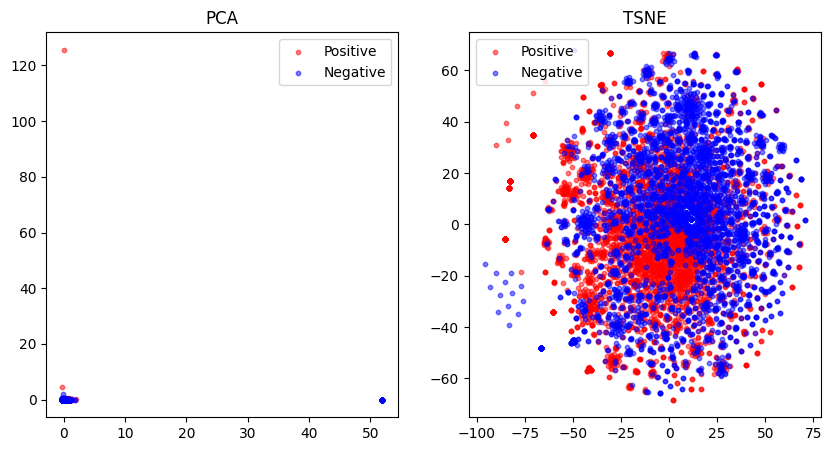

In [16]:
#plot pca and tsne
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(tf_idf_matrix_pca[:4000,0],tf_idf_matrix_pca[:4000,1],color = 'r',label = 'Positive',s=10,alpha=0.5)
plt.scatter(tf_idf_matrix_pca[4000:,0],tf_idf_matrix_pca[4000:,1],color = 'b',label = 'Negative',s=10,alpha=0.5)
plt.title("PCA")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(tf_idf_matrix_tsne[:4000,0],tf_idf_matrix_tsne[:4000,1],color = 'r',label = 'Positive',alpha=0.5,s=10)
plt.scatter(tf_idf_matrix_tsne[4000:,0],tf_idf_matrix_tsne[4000:,1],color = 'b',label = 'Negative',alpha=0.5,s=10)
plt.title("TSNE")
plt.legend()

## Classify the tweets

In [17]:
#shuffle the data
np.random.seed(42)
N = len(train_y)

shuffle_index = np.random.permutation(N)

tf_idf_matrix_train = tf_idf_matrix_train[shuffle_index]
train_y = train_y[shuffle_index]

In [18]:
#Create the model
model_lr = LogisticRegression()

#Cross validation
scores_lr = cross_val_score(model_lr,tf_idf_matrix_train,train_y,cv=5,scoring='accuracy')

print("The accuracy of the model is ",scores_lr.mean())

model_lr.fit(tf_idf_matrix_train,train_y)


The accuracy of the model is  0.9942499999999999


LogisticRegression()

In [19]:
model_lr.score(tf_idf_matrix_train,train_y)

0.99975

In [20]:
#valdate the model on test data
y_pred_test = model_lr.predict(tf_idf_matrix_test)

In [21]:
#Get the accuracy
accuracy = accuracy_score(test_y,y_pred_test)

In [22]:
accuracy

0.9965

### Try with CSO and comapre the result

In [23]:
#add 1 to the data for the bias
tf_idf_matrix_train_1 = np.c_[tf_idf_matrix_train,np.ones(8000)]
tf_idf_matrix_test_1 = np.c_[tf_idf_matrix_test,np.ones(2000)]

In [24]:
#hypitheresis function
def h_lr(w,x):
    return 1/(1+np.exp(-np.dot(x,w)))

#Loss function
def loss_lr(w):
    x,y=tf_idf_matrix_train_1,train_y
    h = h_lr(w,x).reshape(-1)
    h = np.clip(h,1e-10,1-1e-10)
    return -np.mean(y*np.log(h) + (1-y)*np.log(1-h))

In [25]:
vocab_size+1

10693

In [26]:
vocab_size

10692

In [27]:
#hyperparameters
min_values = [-1]*(vocab_size+1)
max_values = [1]*(vocab_size+1)

losses,best_cat = cso.cat_swarm_optimization(size = 15, min_values = min_values, max_values = max_values, generations = 100, mixture_ratio = 0.2, seeking_range = 0.2, dim_change = 100, c1 = 0.5, target_function = loss_lr, verbose = True, start_init = None, target_value = None)


Generation:  0  f(x) =  3.02045048330676
Generation:  1  f(x) =  3.0085617286771478
Generation:  2  f(x) =  2.997797245498794
Generation:  3  f(x) =  2.9838942848005034
Generation:  4  f(x) =  2.9765097758489723
Generation:  5  f(x) =  2.9643368996468764
Generation:  6  f(x) =  2.9418644210855938
Generation:  7  f(x) =  2.931601592607627
Generation:  8  f(x) =  2.9189524970630263
Generation:  9  f(x) =  2.9040244124749406
Generation:  10  f(x) =  2.8923600801521125
Generation:  11  f(x) =  2.8773979122807742
Generation:  12  f(x) =  2.862961000054447
Generation:  13  f(x) =  2.8574050089214835
Generation:  14  f(x) =  2.8455196460902523
Generation:  15  f(x) =  2.8350920737537297
Generation:  16  f(x) =  2.82768415304524
Generation:  17  f(x) =  2.8158225366043594
Generation:  18  f(x) =  2.7980885510062836
Generation:  19  f(x) =  2.7901453929028586
Generation:  20  f(x) =  2.7816573355222074
Generation:  21  f(x) =  2.7681539973534997
Generation:  22  f(x) =  2.7566702927656164
Gener

In [ ]:
N = W.shape

(10693, 1)